In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi,tdrstyle
tdrstyle.setTDRStyle()
rt.gROOT.SetBatch()
rt.gROOT.ForceStyle()
rt.gStyle.SetOptStat(0)
%jsroot on

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Do unfolding

In [5]:
def DoUnfolding(Response,Data_reco,SysUnc,HSname,MCname,gen_bins):
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            tunfolderData.AddSysError(SysUnc[source+ud],source+ud,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfoldSys.kSysErrModeMatrix)
    
    tunfolderData.DoUnfold(0.)
    
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    N=Data_unfolded.GetNbinsX()
    
    Data_unfolded_SysUnc_1sigma=Data_unfolded.Clone("Data with 1 #sigma Systematic Uncertainties")
    Data_unfolded_SysUncSeries_1sigma={}
    SysUnc_1sigma=Data_unfolded.Clone("1 #sigma Systematic Uncertainties")
    SysUnc_1sigma.Reset()
    SysUncSeries_1sigma={}

    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            SysUncSeries_1sigma[source+ud]=tunfolderData.GetDeltaSysSource(source+ud, "1 #sigma Systematic Uncertainties:"+source+ud, "-1#sigma")
            Data_unfolded_SysUncSeries_1sigma[source+ud]=Data_unfolded.Clone("Data_unfolded with 1 #sigma Systematic Uncertainties:"+source+ud)
            for i in range(1,N+1):
                Data_unfolded_SysUncSeries_1sigma[source+ud].SetBinError(i,SysUncSeries_1sigma[source+ud].GetBinContent(i))
        SysUncSeries_1sigma[source+"Total"]=SysUncSeries_1sigma[source+"Up"].Clone("1 #sigma Systematic Uncertainties:"+source+"Total")
        SysUncSeries_1sigma[source+"Total"].Reset()
        Data_unfolded_SysUncSeries_1sigma[source+"Total"]=Data_unfolded.Clone("Data_unfolded with 1 #sigma Systematic Uncertainties:"+source+"Total")
        for i in range(1,N+1):
            sys1=SysUncSeries_1sigma[source+"Up"].GetBinContent(i)
            sys2=SysUncSeries_1sigma[source+"Down"].GetBinContent(i)
            SysUncSeries_1sigma[source+"Total"].SetBinContent(i,np.sqrt(sys1**2+sys2**2))
            Data_unfolded_SysUncSeries_1sigma[source+"Total"].SetBinError(i,np.sqrt(sys1**2+sys2**2))
        SysUnc_1sigma.Add(SysUncSeries_1sigma[source+"Total"])
    for i in range(1,N+1):
        Data_unfolded_SysUnc_1sigma.SetBinError(i,SysUnc_1sigma.GetBinContent(i))
    
    tunfolderCheck={}
    Data_unfolded_SysUncSeries_Check={}
    SysUncSeries_Check={}
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            tunfolderCheck[source+ud]=rt.TUnfoldDensity(SysUnc[source+ud],rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
            tunfolderCheck[source+ud].SetInput(Data_reco)
            tunfolderCheck[source+ud].DoUnfold(0.)
            Data_unfolded_SysUncSeries_Check[source+ud]=tunfolderCheck[source+ud].GetOutput("Systematic Uncertainties Check:"+source+ud)
            SysUncSeries_Check[source+ud]=Data_unfolded_SysUncSeries_Check[source+ud].Clone()
            SysUncSeries_Check[source+ud].Add(Data_unfolded,-1.)
            
    #for source in ['jesTotal',"jer","pu"]:
    #    SysUncSeries_1sigma[source+"Total"].Divide(Data_unfolded)
    
    Data_unfolded_SysUnc_1sigma.SetMarkerStyle(22)
    Data_unfolded_SysUnc_1sigma.SetMarkerColor(1)
    Data_unfolded_SysUnc_1sigma.SetLineColor(1)
    Data_unfolded_SysUnc_1sigma.SetLineWidth(2)
    
    SysUnc_1sigma.SetMarkerStyle(22)
    SysUnc_1sigma.SetMarkerColor(1)
    SysUnc_1sigma.SetLineColor(1)
    SysUnc_1sigma.SetLineWidth(2) 
   
    i=0
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            SysUncSeries_1sigma[source+ud].SetMarkerStyle(24)
            SysUncSeries_1sigma[source+ud].SetMarkerColor(rt.kBlue-i)
            SysUncSeries_1sigma[source+ud].SetLineColor(rt.kBlue-i)
            SysUncSeries_1sigma[source+ud].SetLineWidth(2)
            SysUncSeries_Check[source+ud].SetMarkerStyle(24)
            SysUncSeries_Check[source+ud].SetMarkerColor(rt.kRed-i)
            SysUncSeries_Check[source+ud].SetLineColor(rt.kRed-i)
            SysUncSeries_Check[source+ud].SetLineWidth(2)
            i+=1
        SysUncSeries_1sigma[source+"Total"].SetMarkerStyle(24)
        SysUncSeries_1sigma[source+"Total"].SetMarkerColor(rt.kBlue-i)
        SysUncSeries_1sigma[source+"Total"].SetLineColor(rt.kBlue-i)
        SysUncSeries_1sigma[source+"Total"].SetLineWidth(2)
        i+=1
    
    i=0
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            Data_unfolded_SysUncSeries_1sigma[source+ud].SetMarkerStyle(24)
            Data_unfolded_SysUncSeries_1sigma[source+ud].SetMarkerColor(rt.kBlue-i)
            Data_unfolded_SysUncSeries_1sigma[source+ud].SetLineColor(rt.kBlue-i)
            Data_unfolded_SysUncSeries_1sigma[source+ud].SetLineWidth(2)
            Data_unfolded_SysUncSeries_Check[source+ud].SetMarkerStyle(24)
            Data_unfolded_SysUncSeries_Check[source+ud].SetMarkerColor(rt.kRed-i)
            Data_unfolded_SysUncSeries_Check[source+ud].SetLineColor(rt.kRed-i)
            Data_unfolded_SysUncSeries_Check[source+ud].SetLineWidth(2)
            i+=1
        Data_unfolded_SysUncSeries_1sigma[source+"Total"].SetMarkerStyle(24)
        Data_unfolded_SysUncSeries_1sigma[source+"Total"].SetMarkerColor(rt.kBlue-i)
        Data_unfolded_SysUncSeries_1sigma[source+"Total"].SetLineColor(rt.kBlue-i)
        Data_unfolded_SysUncSeries_1sigma[source+"Total"].SetLineWidth(2)
        i+=1
    
    hs=rt.THStack(HSname,HSname)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            Data_unfolded_SysUncSeries_Check[source+ud].Scale(1,"width")
            hs.Add(Data_unfolded_SysUncSeries_Check[source+ud],"Hist")
    Data_unfolded_SysUnc_1sigma.Scale(1,"width")
    hs.Add(Data_unfolded_SysUnc_1sigma,"E")
    
    leg=rt.TLegend(0.4, 0.2, 0.9, 0.8)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            leg.AddEntry(Data_unfolded_SysUncSeries_Check[source+ud],"Data_unfolded from Systematic Error "+source+ud,"f")
    leg.AddEntry(Data_unfolded_SysUnc_1sigma,"Data_unfolded with systematic uncertainties",'lep')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    '''
    hs_unc=rt.THStack("Systematic Uncertainties "+HSname,"Systematic Uncertainties "+HSname)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            hs_unc.Add(SysUncSeries_1sigma[source+ud],"Hist")
        
    leg_unc=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            leg_unc.AddEntry(SysUncSeries_1sigma[source+ud],source+ud,"f")
    leg_unc.SetLineColor(0)
    leg_unc.SetBorderSize(0)
    leg_unc.SetFillStyle(0)
    '''
    hs_unc_=rt.THStack("Systematic Uncertainties "+HSname,"Systematic Uncertainties "+HSname)
    for source in ['jesTotal',"jer","pu"]:
        hs_unc_.Add(SysUncSeries_1sigma[source+"Total"])
    
    leg_unc_=rt.TLegend(0.2, 0.5, 0.5, 0.8)
    for source in ['jesTotal',"jer","pu"]:
        leg_unc_.AddEntry(SysUncSeries_1sigma[source+"Total"],source+"Total","f")
    leg_unc_.SetLineColor(0)
    leg_unc_.SetBorderSize(0)
    leg_unc_.SetFillStyle(0)
    
    hs_check={}
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            hs_check[source+ud]=rt.THStack("Systematic Uncertainty Check "+source+ud+":"+HSname,"Systematic Uncertainty Check "+source+ud+":"+HSname)
            #hs_check[source+ud].Add(SysUncSeries_2sigma[source+ud],"E")
            hs_check[source+ud].Add(SysUncSeries_1sigma[source+ud],"Hist")
            hs_check[source+ud].Add(SysUncSeries_Check[source+ud],"E")
    
    leg_check={}
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            leg_check[source+ud]=rt.TLegend(0.3, 0.6, 0.9, 0.9,source+ud)
            #leg_check[source+ud].AddEntry(SysUncSeries_2sigma[source+ud],"2 #sigma shift "+source+ud,"lep")
            leg_check[source+ud].AddEntry(SysUncSeries_1sigma[source+ud],"1 #sigma shift from AddSysError","f")
            leg_check[source+ud].AddEntry(SysUncSeries_Check[source+ud],"Shift from Unfolding with Resp_SysUnc","lep")
            leg_check[source+ud].SetLineColor(0)
            leg_check[source+ud].SetBorderSize(0)
            leg_check[source+ud].SetFillStyle(0)
    
    return hs,leg,hs_unc_,leg_unc_,hs_check,leg_check

# $\tau_1^{(1)}$

In [6]:
reco='recoJet_tau_0p5_0_nom_dijetSel'
gen='genJet_tau_0p5_0_dijetSel'
response='respJet_tau_0p5_0_nom_dijetSel'
sysunc={}
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        sysunc[source+ud]='respJet_tau_0p5_0_'+source+ud+'_dijetSel'
        print sysunc[source+ud]

respJet_tau_0p5_0_jesTotalUp_dijetSel
respJet_tau_0p5_0_jesTotalDown_dijetSel
respJet_tau_0p5_0_jerUp_dijetSel
respJet_tau_0p5_0_jerDown_dijetSel
respJet_tau_0p5_0_puUp_dijetSel
respJet_tau_0p5_0_puDown_dijetSel


In [7]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{21};Events/0.01",100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{21};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{21};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{21};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{21};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{21} gen;#tau_{21} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{21} gen;#tau_{21} reco",100,0,1,100,0,1)
SysUnc1_0={}
SysUnc2_0={}
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        SysUnc1_0[source+ud]=rt.TH2D('Unc1:'+source+ud,'Unc1:'+source+ud+';#tau_{21} gen;#tau_{21} reco',100,0,1,100,0,1)
        SysUnc2_0[source+ud]=rt.TH2D('Unc2:'+source+ud,'Unc2:'+source+ud+';#tau_{21} gen;#tau_{21} reco',100,0,1,100,0,1)
    
f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
#MC1_reco0.Add(t.Get(reco),Scale[i])
#MC1_gen0.Add(t.Get(gen),Scale[i])
MC1_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
MC1_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        SysUnc1_0[source+ud].Add(t.Get(sysunc[source+ud]),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            SysUnc2_0[source+ud].Add(t.Get(sysunc[source+ud]),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,2520)
c0.Divide(3,7)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()
i=10
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        c0.cd(i)
        SysUnc1_0[source+ud].Draw("Colz")
        i+=1
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        c0.cd(i)
        SysUnc2_0[source+ud].Draw("Colz")
        i+=1

In [8]:
gen_bins=np.array([0.0,0.12,0.18,0.24,0.3,0.36,0.42,0.48,0.54,0.6,0.66,0.72,0.81])
reco_bins=np.array([0.0,0.06,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.51,0.54,0.57,0.6,0.63,0.66,0.69,0.72,0.76,0.81])
print gen_bins,gen_bins.shape[0]-1
print reco_bins,reco_bins.shape[0]-1

[0.   0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.81] 12
[0.   0.06 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39 0.42 0.45
 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.76 0.81] 24


In [9]:
gen_bin=gen_bins
reco_bin=reco_bins
    
Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{21};Events",reco_bin.shape[0]-1,reco_bin)
MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{21};Events",reco_bin.shape[0]-1,reco_bin)
MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{21};Events",gen_bin.shape[0]-1,gen_bin)
Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{21} gen;#tau_{21} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
SysUnc2={}
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        SysUnc2[source+ud]=rt.TH2D('Unc:'+source+ud,'Unc:'+source+ud+';#tau_{21} gen;#tau_{21} reco',gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)

Fill1D(Data_reco0,Data_reco,reco_bin)
Fill1D(MC2_reco0,MC2_reco,reco_bin)
Fill1D(MC2_gen0,MC2_gen,gen_bin)
Fill2D(Response2_0,Response2,gen_bin,reco_bin)
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        Fill2D(SysUnc2_0[source+ud],SysUnc2[source+ud],gen_bin,reco_bin)

Response2.SetTitle("Response Matrix #tau_{21} binning %d"%(i+1))
Response2.SetStats(0)
    
Data_reco.Scale(1.0/Data_reco.Integral())
MC2_reco.Scale(1.0/MC2_reco.Integral())
MC2_gen.Scale(1.0/MC2_gen.Integral())
    
hs,leg,hs_unc_,leg_unc_,hs_check,leg_check=DoUnfolding(Response2,Data_reco,SysUnc2,"#tau_{1}^{0.5}","QCD pt-binned",gen_bin)

Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 24 input bins and 12 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{21} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #13 (xaxis:#tau_{21} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 24 input bins and 12 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{21} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #13 (xaxis:#tau_{21} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: 

In [10]:
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
#CMS_lumi.CMS_lumi(pad1,4,0)

c=rt.TCanvas("","",0,0,1024,720)
hs.SetTitle("Data_unfolded #tau_{1}^{0.5}")
hs.Draw("nostack")
hs.GetXaxis().SetTitle("#tau_{1}^{0.5}")
hs.GetYaxis().SetTitle( '#frac{1}{d#sigma}#frac{d#sigma}{d(#tau_{1}^{(0.5)})}' )
hs.GetYaxis().SetTitleOffset(0.85)
hs.GetXaxis().SetTitleSize(0.05)
leg.Draw("same")
CMS_lumi.CMS_lumi(c,4,0)
c.SaveAs("/t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/All.png")
c.Draw()#error->uncertainties

python ERROR: cannot open image file "/t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/All.png" for writing. Please check permissions.
Error in <TASImage::WriteImage>: error writing file /t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/All.png


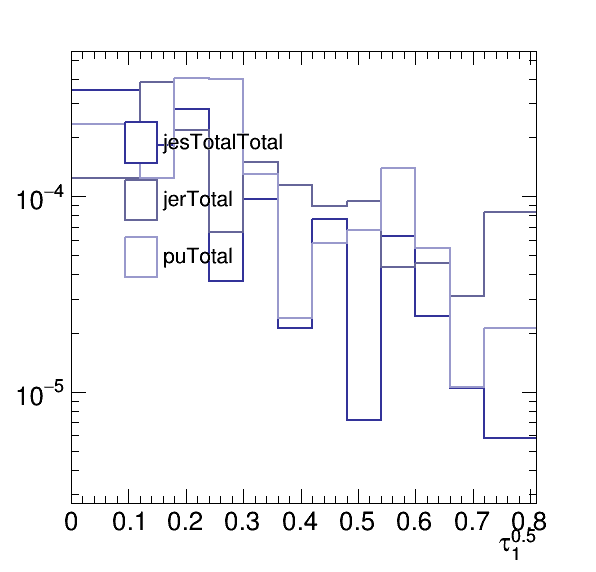

In [11]:
c=rt.TCanvas()
c.SetLogy()
hs_unc_.SetTitle("Relative Systematic Uncertainties #tau_{1}^{0.5}")
hs_unc_.Draw("nostack")
hs_unc_.GetXaxis().SetTitle("#tau_{1}^{0.5}")
hs_unc_.GetXaxis().SetTitleSize(0.05)
leg_unc_.Draw("Same")
c.Draw()

In [14]:
#c=rt.TCanvas("","",0,0,720*2,480*3)
#c.Divide(2,3)
i=1
for source in ['jesTotal',"jer","pu"]:
    for ud in ['Up','Down']:
        #c.cd(i)
        c=rt.TCanvas("","",0,0,720,480)
        hs_check[source+ud].SetTitle("Systematic Uncertainty Check "+source+ud)
        hs_check[source+ud].GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
        hs_check[source+ud].SetMaximum(0.0008)
        hs_check[source+ud].SetMinimum(-0.0005)
        hs_check[source+ud].Draw("nostack")
        leg_check[source+ud].Draw("same")
        CMS_lumi.CMS_lumi(c,4,0)
        c.SaveAs("/t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/"+source+ud+".png")
        i+=1
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/jesTotalUp.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/jesTotalDown.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/jerUp.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/Unfolding/QCD_pythia8_ptbinned_dijetSel/SysUnc/jerDown.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: 

In [13]:
%jsroot on